# Imports

In [396]:
import os

# working with datasets
import kaggle
import pandas as pd
import requests

# plots and visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# methods for training
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score

# learning models 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Aditional plot and dataset methods

In [397]:
def show_relplot(X, Y, title, xlabel=None, ylabel=None, hue=None, set_ticks=False, line_kind=False, aspect=1.0, draw_axhline=False, axhline_point=0, palette=None):
    sns.set_style(style='whitegrid')

    if line_kind:
        sns.relplot(x=X, y=Y, hue=hue, kind='line', aspect=aspect, palette=palette)
    else:
        sns.relplot(x=X, y=Y, hue=hue, aspect=aspect, palette=palette)

    if draw_axhline:
        plt.axhline(axhline_point, color='lime', linestyle='-') 


    plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    if set_ticks:
        plt.xticks(rotation=45)
        plt.gca().set_xticks(X)

    plt.tight_layout()
    plt.savefig(f'plots/{title}.png')
    plt.show()

def show_scatterplot(X, Y, title, xlabel, ylabel, hue=None, draw_axhline=False, axhline_point=0, palette=None):
    sns.scatterplot(x=X, y=Y, hue=hue, palette=palette)

    if draw_axhline:
        plt.axhline(axhline_point, color='lime', linestyle='-') 

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    plt.savefig(f'plots/{title}.png')
    plt.show()

Useful methods for work with datasets

In [398]:
def download_dataset_from_kaggle(filename, dataset_path):
    if not os.path.isfile(filename):
        print(f'Downloading csv dataset from Kaggle...')
        kaggle.api.dataset_download_files(dataset_path, path='datasets', unzip=True)

    return pd.read_csv(filename)

def filter_by_year(dataset, start_year, end_year):
    if start_year > end_year:
        raise ValueError('start_year must be less than end_year')

    filtered_dataset = (dataset[
                            (dataset['Year'] >= start_year) &
                            (dataset['Year'] <= end_year)
                            ]
                        .reset_index()
                        .drop('index', axis=1))

    return filtered_dataset

# Downloading data

### Downloading datasets and checking for missing data

In this dataset there is one missing value in 1917 year witch is replaced with 0. We wont need such old data for analysis

In [399]:
def get_temperature_data():
    dataset_path = 'sarahquesnelle/canada-data'
    filename = 'datasets/Canada_Temperature_Data.csv'

    data = download_dataset_from_kaggle(filename, dataset_path)
    data['P'] = pd.to_numeric(data['P'], errors='coerce').fillna(0)

    print("Raw data:")
    print(data.info())

    # reformatting data and storing annual values
    annual_mean_temperatures = data.groupby('Year').agg({
        'Tm': 'mean',
        'S': 'sum',
        'P': 'sum'
    }).reset_index()

    annual_mean_temperatures.columns = ['Year', 'Mean Temperature', 'Total Snowfall', 'Total Precipitation']

    return annual_mean_temperatures

mean_temp_data = get_temperature_data()

Raw data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357283 entries, 0 to 1357282
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Year      1357283 non-null  int64  
 1   Month     1357283 non-null  int64  
 2   Stn_Name  1357283 non-null  object 
 3   Prov      1357283 non-null  object 
 4   Tm        1357283 non-null  float64
 5   S         1357283 non-null  float64
 6   P         1357283 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 72.5+ MB
None


In [400]:
def get_sold_cars_data():
    # gets amount of sold cars between
    url = ("https://www150.statcan.gc.ca/t1/tbl1/en/dtl!downloadDbLoadingData-nonTraduit.action?pid=2010000101"
           "&latestN=0&startDate=19460101&endDate=20231201&csvLocale=en&selectedMembers=%5B%5B1%5D%2C%5B1%5D%2C%5B1"
           "%5D%2C%5B1%2C2%5D%2C%5B1%5D%5D&checkedLevels=")
    filename = "datasets/sold_cars_units_1946-2023.csv"

    if not os.path.isfile(filename):
        response = requests.get(url)

        if response.status_code == 200:
            with open(filename, "wb") as file:
                file.write(response.content)
            print("File downloaded successfully!")
        else:
            print("Failed to retrieve the file. Status code:", response.status_code)

    data = pd.read_csv(filename)

    print("Raw data:")
    print(data.info())

    # reformatting data and storing annual values
    data['Year'] = data['REF_DATE'].str.split('-').str[0]
    data['Year'] = pd.to_numeric(data['Year'])
    annual_values = data.groupby('Year')['VALUE'].sum().reset_index()
    annual_values.columns = ['Year', 'Amount']

    return annual_values

sold_cars_data = get_sold_cars_data()

Raw data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872 entries, 0 to 1871
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   REF_DATE               1872 non-null   object 
 1   GEO                    1872 non-null   object 
 2   DGUID                  1872 non-null   object 
 3   Vehicle type           1872 non-null   object 
 4   Origin of manufacture  1872 non-null   object 
 5   Sales                  1872 non-null   object 
 6   Seasonal adjustment    1872 non-null   object 
 7   UOM                    1872 non-null   object 
 8   UOM_ID                 1872 non-null   int64  
 9   SCALAR_FACTOR          1872 non-null   object 
 10  SCALAR_ID              1872 non-null   int64  
 11  VECTOR                 1872 non-null   object 
 12  COORDINATE             1872 non-null   object 
 13  VALUE                  1872 non-null   int64  
 14  STATUS                 0 non-null      float64

Some data in columns have same string but in different cases, we need to make them all uppercase to have same strings.

Vehicle Class column have same vehicle types written with different separators, we also changing that to same strings.

Also we need to remap FUEL column so it will contain . Every fuel type will be remaped to integers
 - X = Regular gasoline
 - Z = Premium gasoline
 - D = Diesel
 - E = Ethanol (E85)
 - N = Natural Gas

In [401]:
def get_fuel_consumption():
    dataset_path = 'ahmettyilmazz/fuel-consumption'
    filename = 'datasets/Fuel_Consumption_2000-2022.csv'

    data = download_dataset_from_kaggle(filename, dataset_path)

    print("Raw data:")
    print(data.info())

    # reformatting data in columns
    for col in data.columns:
        if data[col].dtype == 'object':
            data[col] = data[col].str.upper()
    data['VEHICLE CLASS'] = data['VEHICLE CLASS'].str.replace(': ', ' - ')
    
    fuel_map = {'X': 'Regular gasoline', 'Z': 'Premium gasoline', 'D': 'Diesel', 'E': 'Ethanol (E85)', 'N': 'Natural Gas'}
    data['FUEL'] = data['FUEL'].map(fuel_map)

    return data

cars_and_fuel_con = get_fuel_consumption()

Raw data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22556 entries, 0 to 22555
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              22556 non-null  int64  
 1   MAKE              22556 non-null  object 
 2   MODEL             22556 non-null  object 
 3   VEHICLE CLASS     22556 non-null  object 
 4   ENGINE SIZE       22556 non-null  float64
 5   CYLINDERS         22556 non-null  int64  
 6   TRANSMISSION      22556 non-null  object 
 7   FUEL              22556 non-null  object 
 8   FUEL CONSUMPTION  22556 non-null  float64
 9   HWY (L/100 km)    22556 non-null  float64
 10  COMB (L/100 km)   22556 non-null  float64
 11  COMB (mpg)        22556 non-null  int64  
 12  EMISSIONS         22556 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 2.2+ MB
None


In [402]:
def get_demographics():
    url = 'https://en.wikipedia.org/wiki/Demographics_of_Canada'
    filename = 'datasets/Demographics_of_Canada.csv'

    if not os.path.isfile(filename):
        dfs = pd.read_html(url, header=0)
        
        for df in dfs:
            if 'Average population (on July 1)' in df.columns:

                df = df.iloc[:, :2]
                df.columns = ['Year', 'Average Population']
    
                df.to_csv(filename, index=False)
                break

    return pd.read_csv(filename)

demographics_data = get_demographics()

In [403]:
cars_and_fuel_con.head()

,YEAR,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,Regular gasoline,9.2,6.7,8.1,35,186
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,Regular gasoline,8.5,6.5,7.6,37,175
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Premium gasoline,12.2,7.4,10.0,28,230
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Premium gasoline,13.4,9.2,11.5,25,264
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,Regular gasoline,10.0,7.0,8.6,33,198


In [404]:
sold_cars_data.head()

,Year,Amount
0,1946,313373
1,1947,646494
2,1948,660518
3,1949,875066
4,1950,1315365


In [405]:
mean_temp_data.head()

,Year,Mean Temperature,Total Snowfall,Total Precipitation
0,1917,3.397697,71993.4,282321.6
1,1918,4.601561,61197.0,299492.6
2,1919,4.422720,62713.9,294860.5
3,1920,4.473663,66841.0,299336.7
4,1921,5.045527,67793.2,323221.2


In [406]:
demographics_data.head()

,Year,Average Population
0,1900,5500000
1,1901,5600000
2,1902,5760000
3,1903,5930000
4,1904,6100000


# Checking for missing data


In [407]:
cars_and_fuel_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22556 entries, 0 to 22555
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              22556 non-null  int64  
 1   MAKE              22556 non-null  object 
 2   MODEL             22556 non-null  object 
 3   VEHICLE CLASS     22556 non-null  object 
 4   ENGINE SIZE       22556 non-null  float64
 5   CYLINDERS         22556 non-null  int64  
 6   TRANSMISSION      22556 non-null  object 
 7   FUEL              22556 non-null  object 
 8   FUEL CONSUMPTION  22556 non-null  float64
 9   HWY (L/100 km)    22556 non-null  float64
 10  COMB (L/100 km)   22556 non-null  float64
 11  COMB (mpg)        22556 non-null  int64  
 12  EMISSIONS         22556 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 2.2+ MB


In [408]:
sold_cars_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Year    78 non-null     int64
 1   Amount  78 non-null     int64
dtypes: int64(2)
memory usage: 1.3 KB


In [409]:
mean_temp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 101 non-null    int64  
 1   Mean Temperature     101 non-null    float64
 2   Total Snowfall       101 non-null    float64
 3   Total Precipitation  101 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 3.3 KB


In [410]:
demographics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Year                124 non-null    int64
 1   Average Population  124 non-null    int64
dtypes: int64(2)
memory usage: 2.1 KB


There is no missing data so we dont need to handle it.

# Dependencies between data

### Amount of sold cars

In [411]:
start_year = 2000
end_year = 2022

sold_cars_filtered = filter_by_year(sold_cars_data, start_year, end_year)
sold_cars_filtered.head()

,Year,Amount
0,2000,48518075
1,2001,48484216
2,2002,53960817
3,2003,52119776
4,2004,51214418


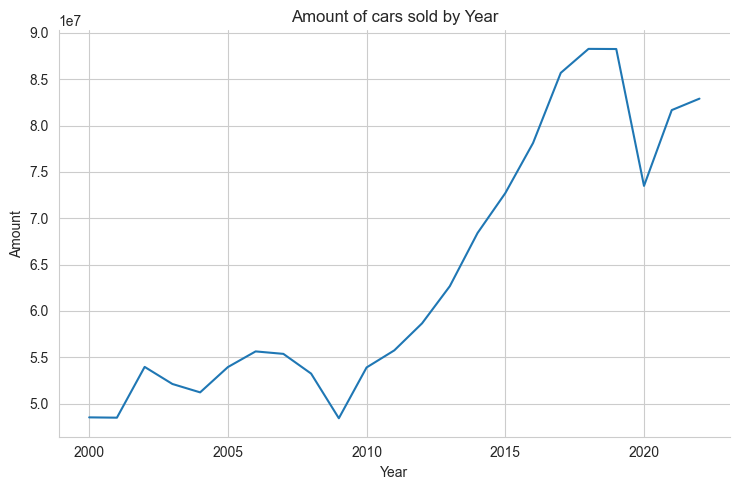

In [412]:
show_relplot(sold_cars_filtered['Year'], sold_cars_filtered['Amount'], 'Amount of cars sold by Year', line_kind=True, aspect=1.5)

### Mean temperatures

In [413]:
# MEAN TEMPERATURE VALUES
start_year = 2000
end_year = 2017

mean_temp_filtered = filter_by_year(mean_temp_data, start_year, end_year)
mean_temp_filtered.head()

,Year,Mean Temperature,Total Snowfall,Total Precipitation
0,2000,4.275210,247356.0,1184941.1
1,2001,5.121442,219202.8,1056534.5
2,2002,4.126670,242017.8,1027263.1
3,2003,4.374958,220364.3,1032865.3
4,2004,3.727522,204710.4,903349.4


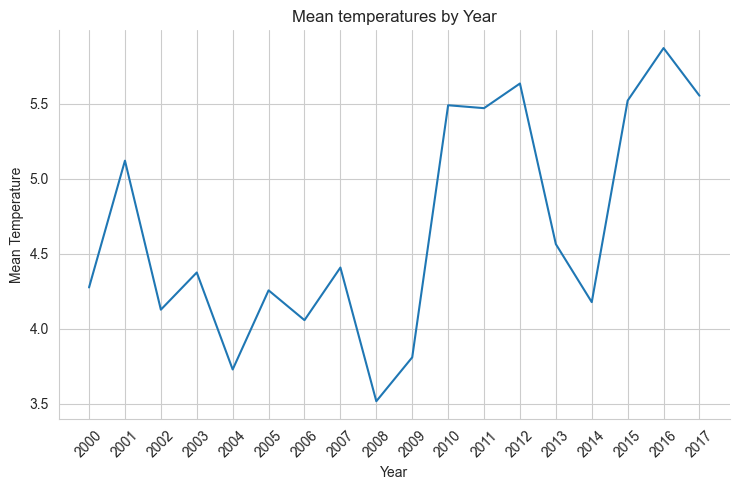

In [414]:
show_relplot(mean_temp_filtered['Year'], mean_temp_filtered['Mean Temperature'], 'Mean temperatures by Year', set_ticks=True, line_kind=True, aspect=1.5)

### Mean temperatures vs Total precipitation

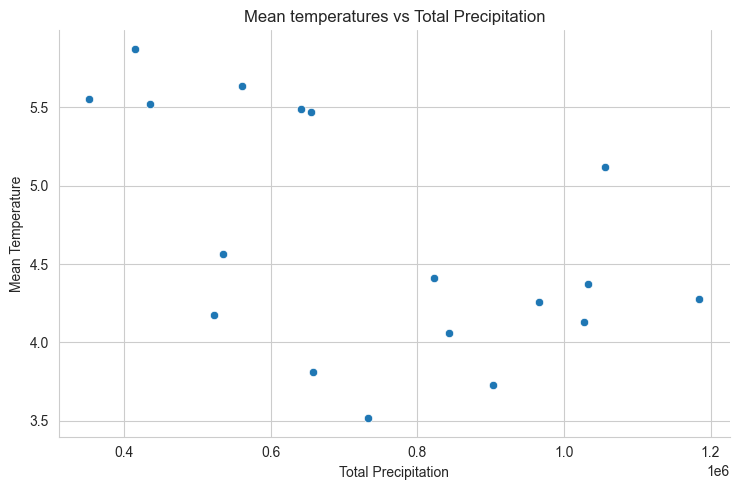

In [415]:
show_relplot(mean_temp_filtered['Total Precipitation'], mean_temp_filtered['Mean Temperature'], 'Mean temperatures vs Total Precipitation', aspect=1.5)

### Average population

In [416]:
start_year = 2000
end_year = 2023

demographics_filtered = filter_by_year(demographics_data, start_year, end_year)
demographics_filtered.head()

,Year,Average Population
0,2000,30685730
1,2001,31020902
2,2002,31360079
3,2003,31644028
4,2004,31940655


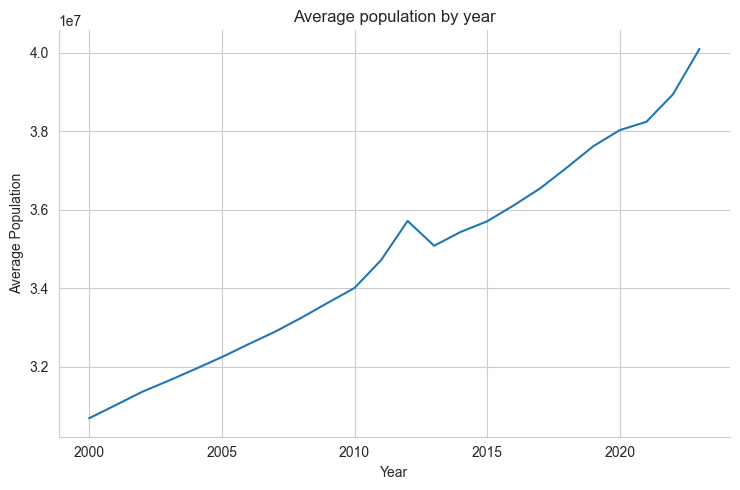

In [417]:
show_relplot(demographics_filtered['Year'], demographics_filtered['Average Population'], 'Average population by year', line_kind=True, aspect=1.5)

### Engine size with fuel consumption

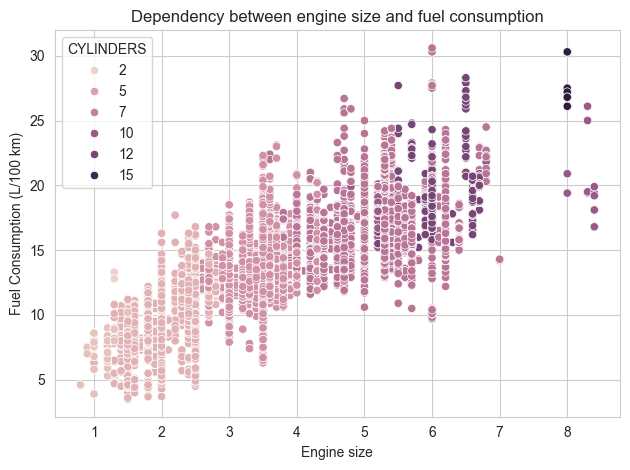

In [418]:
show_scatterplot(cars_and_fuel_con['ENGINE SIZE'], cars_and_fuel_con['FUEL CONSUMPTION'], 'Dependency between engine size and fuel consumption', xlabel='Engine size', ylabel='Fuel Consumption (L/100 km)', hue=cars_and_fuel_con['CYLINDERS'])

### Fuel consumption with emissions

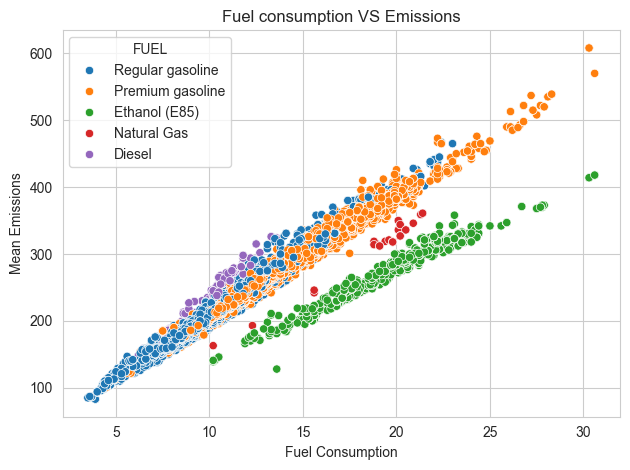

In [419]:
show_scatterplot(cars_and_fuel_con['FUEL CONSUMPTION'], cars_and_fuel_con['EMISSIONS'], 'Fuel consumption VS Emissions', 'Fuel Consumption', 'Mean Emissions', cars_and_fuel_con['FUEL'])

### Yearly emissions

In [420]:
# Yearly emissions
yearly_emissions = cars_and_fuel_con.groupby('YEAR')['EMISSIONS'].mean().reset_index()
yearly_emissions.columns = ['Year', 'Mean Emissions']

yearly_emissions.head()

,Year,Mean Emissions
0,2000,259.696401
1,2001,256.901325
2,2002,263.435135
3,2003,261.028049
4,2004,261.871938


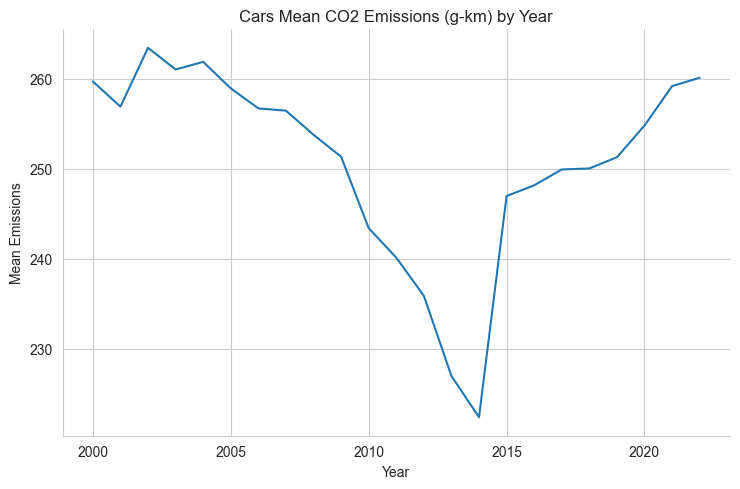

In [421]:
show_relplot(yearly_emissions['Year'], yearly_emissions['Mean Emissions'], 'Cars Mean CO2 Emissions (g-km) by Year', line_kind=True, aspect=1.5)

### Dependency between amount of car emissions and mean temperature

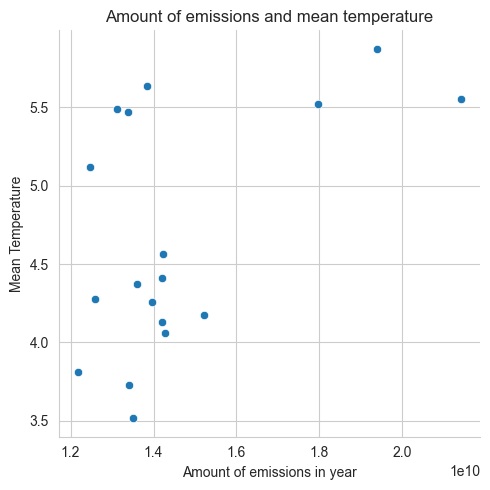

In [422]:
X = yearly_emissions['Mean Emissions'] * sold_cars_filtered['Amount']
Y = mean_temp_filtered['Mean Temperature']

show_relplot(X, Y, 'Amount of emissions and mean temperature', 'Amount of emissions in year')

### Dependency between population and amount of produced cars


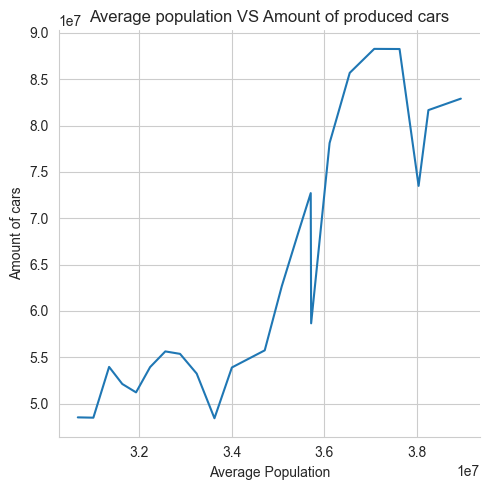

In [423]:
X = demographics_filtered['Average Population']
Y = sold_cars_filtered['Amount']

show_relplot(X, Y, 'Average population VS Amount of produced cars', ylabel='Amount of cars', line_kind=True)

### Dependency between population and mean temperature


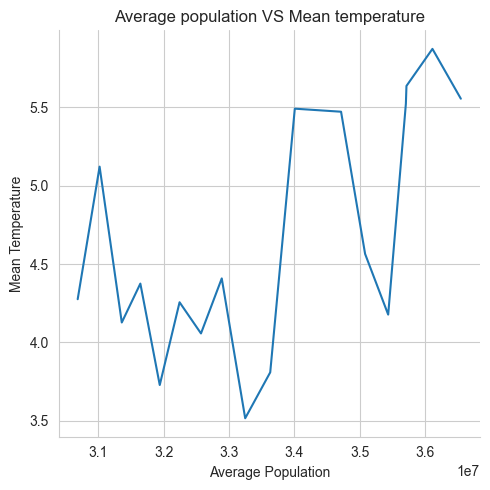

In [424]:
X = demographics_filtered['Average Population']
Y = mean_temp_filtered['Mean Temperature']

show_relplot(X, Y, 'Average population VS Mean temperature', line_kind=True)

### Dependency between population and amount of emissions


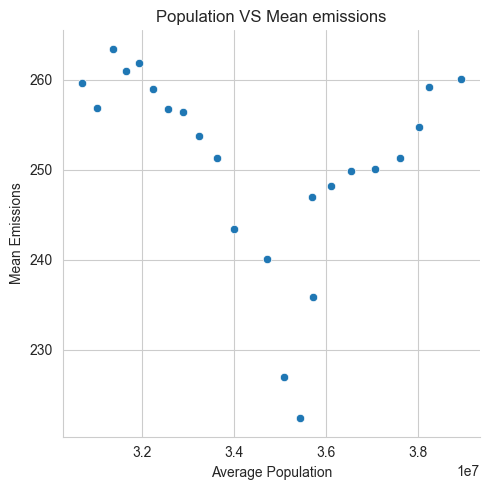

In [425]:
X = demographics_filtered['Average Population']
Y = yearly_emissions['Mean Emissions'] 

show_relplot(X, Y, 'Population VS Mean emissions')

### Dependency between Precipitation and amount of emissions

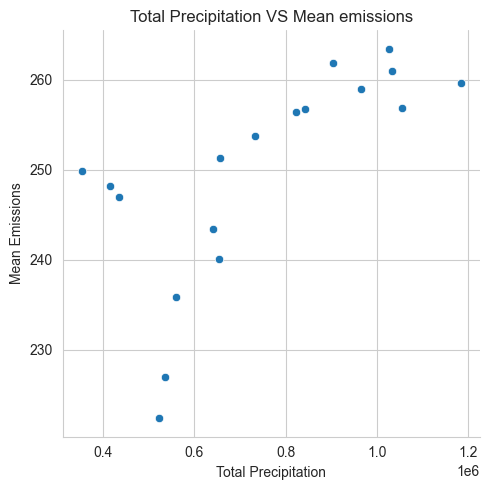

In [426]:
X = mean_temp_filtered['Total Precipitation']
Y = yearly_emissions['Mean Emissions']

show_relplot(X, Y, 'Total Precipitation VS Mean emissions')

# Data preprocessing


### Reformating data

In this dataset we will contain all needed data. Because we have annual values for temperatures, precipitation and population, every year will store same value for one year

In [427]:
cars_and_fuel_con.rename(columns={'YEAR': 'Year'}, inplace=True)
full_data = pd.merge(cars_and_fuel_con, mean_temp_data, on='Year', how='left')
full_data = pd.merge(full_data, demographics_data, on='Year', how='left')
full_data = pd.merge(full_data, sold_cars_data, on='Year', how='left')

full_data.head()

,Year,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS,Mean Temperature,Total Snowfall,Total Precipitation,Average Population,Amount
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,Regular gasoline,9.2,6.7,8.1,35,186,4.27521,247356.0,1184941.1,30685730,48518075
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,Regular gasoline,8.5,6.5,7.6,37,175,4.27521,247356.0,1184941.1,30685730,48518075
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Premium gasoline,12.2,7.4,10.0,28,230,4.27521,247356.0,1184941.1,30685730,48518075
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Premium gasoline,13.4,9.2,11.5,25,264,4.27521,247356.0,1184941.1,30685730,48518075
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,Regular gasoline,10.0,7.0,8.6,33,198,4.27521,247356.0,1184941.1,30685730,48518075


I'll choose period since 2000 - 2017 year because int this scenario we have all needed data

In [428]:
full_data = filter_by_year(full_data, 2000, 2017)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17553 entries, 0 to 17552
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 17553 non-null  int64  
 1   MAKE                 17553 non-null  object 
 2   MODEL                17553 non-null  object 
 3   VEHICLE CLASS        17553 non-null  object 
 4   ENGINE SIZE          17553 non-null  float64
 5   CYLINDERS            17553 non-null  int64  
 6   TRANSMISSION         17553 non-null  object 
 7   FUEL                 17553 non-null  object 
 8   FUEL CONSUMPTION     17553 non-null  float64
 9   HWY (L/100 km)       17553 non-null  float64
 10  COMB (L/100 km)      17553 non-null  float64
 11  COMB (mpg)           17553 non-null  int64  
 12  EMISSIONS            17553 non-null  int64  
 13  Mean Temperature     17553 non-null  float64
 14  Total Snowfall       17553 non-null  float64
 15  Total Precipitation  17553 non-null 

Some of columns are unrelevant so we need to drop it. Also I'm droping another consumption columns because they are calculated based on FUEL CONSUMPTION column

In [429]:
columns_to_drop = ['MAKE','VEHICLE CLASS', 'MODEL', 'TRANSMISSION', 'HWY (L/100 km)', 'COMB (L/100 km)', 'COMB (mpg)', 'EMISSIONS']

full_data.drop(columns_to_drop, axis=1, inplace=True)

Before creating models we need to remap FUEL column to numeric data. Every fuel type will be remaped to integers
 - 1 - X = Regular gasoline
 - 2 - Z = Premium gasoline
 - 3 - D = Diesel
 - 4 - E = Ethanol (E85)
 - 5 - N = Natural Gas

In [430]:
fuel_map = {'Regular gasoline': 1,'Premium gasoline': 2, 'Diesel': 3,'Ethanol (E85)': 4, 'Natural Gas': 5}

full_data['FUEL'] = full_data['FUEL'].map(fuel_map)

In [431]:
full_data.head()

,Year,ENGINE SIZE,CYLINDERS,FUEL,FUEL CONSUMPTION,Mean Temperature,Total Snowfall,Total Precipitation,Average Population,Amount
0,2000,1.6,4,1,9.2,4.27521,247356.0,1184941.1,30685730,48518075
1,2000,1.6,4,1,8.5,4.27521,247356.0,1184941.1,30685730,48518075
2,2000,3.2,6,2,12.2,4.27521,247356.0,1184941.1,30685730,48518075
3,2000,3.5,6,2,13.4,4.27521,247356.0,1184941.1,30685730,48518075
4,2000,1.8,4,1,10.0,4.27521,247356.0,1184941.1,30685730,48518075


In [432]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17553 entries, 0 to 17552
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 17553 non-null  int64  
 1   ENGINE SIZE          17553 non-null  float64
 2   CYLINDERS            17553 non-null  int64  
 3   FUEL                 17553 non-null  int64  
 4   FUEL CONSUMPTION     17553 non-null  float64
 5   Mean Temperature     17553 non-null  float64
 6   Total Snowfall       17553 non-null  float64
 7   Total Precipitation  17553 non-null  float64
 8   Average Population   17553 non-null  int64  
 9   Amount               17553 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 1.3 MB


# Creating models

In [433]:
def get_model_scores(test, predicted):
    return mean_absolute_error(test, predicted), mean_squared_error(test, predicted), root_mean_squared_error(test, predicted), r2_score(test, predicted)

def print_model_scores(test, predicted, model):
    mae, mse, rms, r2 = get_model_scores(test, predicted)
    print(f'{model} Scores:\nMean Absolute Error: {mae}\nMean Squared Error: {mse}\nRoot Mean Squared Error: {rms}\nR2 score: {r2}')

### Creating training and test data

In [457]:
X = full_data[['Year','ENGINE SIZE','CYLINDERS','FUEL','Mean Temperature','Total Snowfall','Total Precipitation','Average Population', 'Amount']]
Y = full_data['FUEL CONSUMPTION']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

## Linear Regresion

In [458]:
model_lin = LinearRegression()
model_lin.fit(X_train, Y_train)

lin_predicted = model_lin.predict(X_test)

In [459]:
print_model_scores(Y_test, lin_predicted, 'Linear Regression')

Linear Regression Scores:
Mean Absolute Error: 1.3035773875684118
Mean Squared Error: 3.1566261597103438
Root Mean Squared Error: 1.7766896633093647
R2 score: 0.7542496268499965


## GLM


In [460]:
glm_model = LinearRegression()
features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
glm_model.fit(features.fit_transform(X_train), Y_train)

glm_predicted = glm_model.predict(features.fit_transform(X_test))

In [461]:
print_model_scores(Y_test, glm_predicted, 'GLM')

GLM Scores:
Mean Absolute Error: 1.3746175093706403
Mean Squared Error: 3.3767370839079995
Root Mean Squared Error: 1.8375900206270166
R2 score: 0.7371135014366124


## XGB

In [462]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, Y_train)

xgb_predicted = xgb_model.predict(X_test)

In [463]:
print_model_scores(Y_test, xgb_predicted, 'XGB')

XGB Scores:
Mean Absolute Error: 0.8870377975163142
Mean Squared Error: 1.5190953863300616
Root Mean Squared Error: 1.2325158767050677
R2 score: 0.8817350426838896


## SVM with StandardScaler

In [464]:
svm_sc_model = SVR(kernel='rbf')
sc = StandardScaler()

sc.fit(X_train)

X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

svm_sc_model.fit(X_train_sc, Y_train)
svm_sc_predicted = svm_sc_model.predict(X_test_sc)

In [465]:
print_model_scores(Y_test, svm_sc_predicted, 'StandardScaler')

StandardScaler Scores:
Mean Absolute Error: 1.0702790642307425
Mean Squared Error: 2.3287405462133752
Root Mean Squared Error: 1.5260211486782793
R2 score: 0.8187023647253834


## Random Forest


In [466]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, Y_train)

random_forest_predicted = random_forest_model.predict(X_test)

In [467]:
print_model_scores(Y_test, random_forest_predicted, 'Random Forest')

Random Forest Scores:
Mean Absolute Error: 0.8948309131197363
Mean Squared Error: 1.5560778249178937
Root Mean Squared Error: 1.2474284848911754
R2 score: 0.8788558775173085


# Comparing models results

This plot shows deviation of predicted values

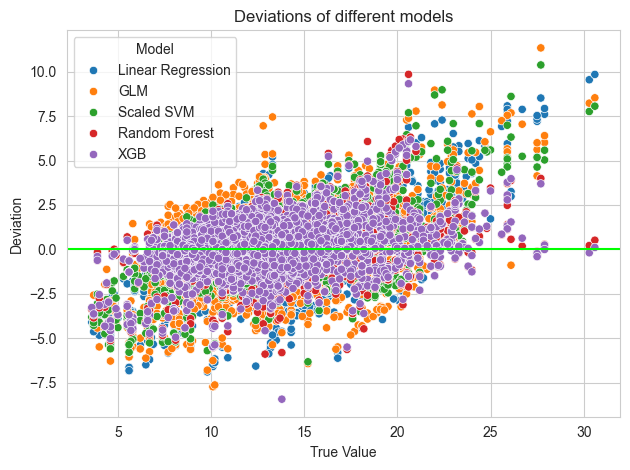

In [473]:
lin_deviation = Y_test - lin_predicted
glm_deviation = Y_test - glm_predicted
xgb_deviation = Y_test - xgb_predicted
svm_sc_deviation = Y_test - svm_sc_predicted
random_forest_deviation = Y_test - random_forest_predicted

deviations = pd.DataFrame({
    'True Value': Y_test,
    'Linear Regression': lin_deviation,
    'GLM': glm_deviation,
    'Scaled SVM': svm_sc_deviation,
    'Random Forest': random_forest_deviation,
    'XGB': xgb_deviation
})

deviations_melted = deviations.melt(id_vars='True Value', var_name='Model', value_name='Deviation')
show_scatterplot(deviations_melted['True Value'], deviations_melted['Deviation'], 'Deviations of different models', xlabel='True Value', ylabel='Deviation', hue=deviations_melted['Model'], draw_axhline=True)

In [469]:
linreg_results = get_model_scores(Y_test, lin_predicted)
glm_results = get_model_scores(Y_test, glm_predicted)
xgb_results = get_model_scores(Y_test, xgb_predicted)
sc_results = get_model_scores(Y_test, svm_sc_predicted)
random_forest_results = get_model_scores(Y_test, random_forest_predicted)

scores = pd.DataFrame({
    'Model': ['Linear Regression', 'GLM', 'XGB', 'Scaled SVM', 'Random Forest'],
    'MAE': [linreg_results[0], glm_results[0], xgb_results[0], sc_results[0], random_forest_results[0]],
    'MSE': [linreg_results[1], glm_results[1], xgb_results[1], sc_results[1], random_forest_results[1]],
    'RMSE': [linreg_results[2], glm_results[2], xgb_results[2], sc_results[2], random_forest_results[2]]
})

scores.head()

,Model,MAE,MSE,RMSE
0,Linear Regression,1.303577,3.156626,1.776690
1,GLM,1.374618,3.376737,1.837590
2,XGB,0.887038,1.519095,1.232516
3,Scaled SVM,1.070279,2.328741,1.526021
4,Random Forest,0.894831,1.556078,1.247428


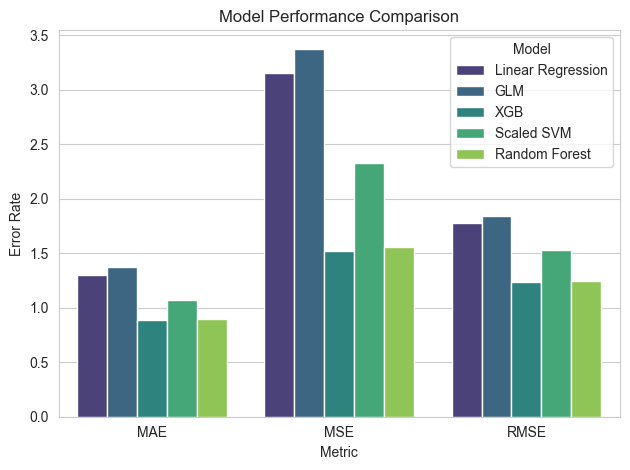

In [470]:
scores_melted = scores.melt(id_vars='Model', var_name='Metric', value_name='Score')

sns.barplot(x='Metric', y='Score', hue='Model', data=scores_melted, palette='viridis')

plt.title('Model Performance Comparison')
plt.ylabel('Error Rate')
plt.xlabel('Metric')
plt.legend(title='Model')

plt.savefig(f'plots/Model Performance Comparison.png')
plt.tight_layout()
plt.show()

In [471]:
r2_scores = pd.DataFrame({
    'Model': ['Linear Regression', 'GLM', 'XGB', 'Scaled SVM', 'Random Forest'],
    'R2': [linreg_results[3], glm_results[3], xgb_results[3], sc_results[3], random_forest_results[3]]
})
r2_scores.head()

,Model,R2
0,Linear Regression,0.754250
1,GLM,0.737114
2,XGB,0.881735
3,Scaled SVM,0.818702
4,Random Forest,0.878856


C:\Users\ymher\AppData\Local\Temp\ipykernel_2420\2660018548.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=r2_scores, palette='rocket')


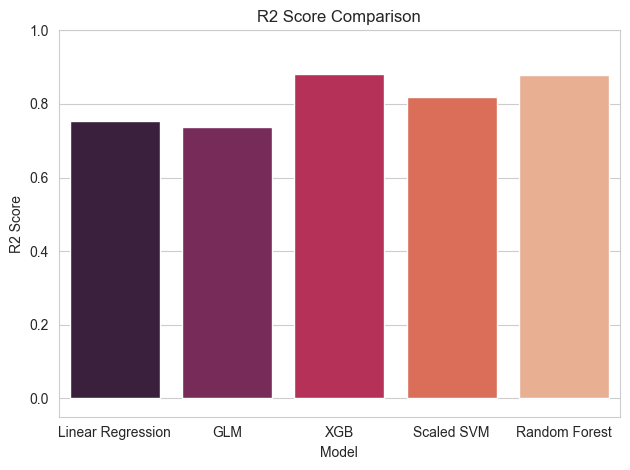

In [472]:
sns.barplot(x='Model', y='R2', data=r2_scores, palette='rocket')

plt.title('R2 Score Comparison')
plt.ylabel('R2 Score')

plt.ylim(-0.05, 1)

plt.savefig(f'plots/R2 Score Comparison.png')
plt.tight_layout()
plt.show()